<a href="https://colab.research.google.com/github/thuviettran/demo-github/blob/main/cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip uninstall -y tensorflow keras jax jaxlib ml_dtypes
!pip install tensorflow==2.16.2 ml-dtypes>=0.5.0


Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2
Found existing installation: ml_dtypes 0.5.4
Uninstalling ml_dtypes-0.5.4:
  Successfully uninstalled ml_dtypes-0.5.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.90 requires jax>=0.4.27, which is not installed.
chex 0.1.90 requires jaxlib>=0.4.27, which is not installed.
optax 0.2.6 requires jax>=0.5.3, which is not installed.
optax 0.2.6 requires jaxlib>=0.5.3, which is not installed.
dopamine-rl 4.1.2 requires ja

In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("Keras OK:", tf.keras is not None)


TF version: 2.16.2
Keras OK: True


In [3]:
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models
optimizers = tf.keras.optimizers


In [4]:
import tensorflow as tf
x = tf.random.normal((1, 64, 64, 3))
y = tf.keras.layers.Conv2D(3, 1)(x)
print(y.shape)


(1, 64, 64, 3)


In [5]:
!git clone https://github.com/SHIDCenter/PathoNet.git
%cd PathoNet
!ls


Cloning into 'PathoNet'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 272 (delta 18), reused 13 (delta 13), pack-reused 246 (from 1)
Receiving objects: 100% (272/272), 3.18 MiB | 44.63 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/PathoNet
config.py  doc		  models.py	    README.md
configs    evaluation.py  pipeline.py	    requirements.txt
data	   LICENSE	  preprocessing.py  train.py
demo.py    logs		  pretrainedmodels  utils.py


In [6]:
import tensorflow as tf

layers = tf.keras.layers
models = tf.keras.models
optimizers = tf.keras.optimizers


In [7]:
layers.Conv2D(...)
models.Model(...)
optimizers.Adam(...)


TypeError: Conv2D.__init__() missing 1 required positional argument: 'kernel_size'

In [8]:
layers.Conv2D(3, (1, 1), activation='linear')


<Conv2D name=conv2d_1, built=False>

In [9]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='mse'
)


NameError: name 'model' is not defined

In [1]:
!pip install -U tensorflow


In [2]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [3]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Add, concatenate, Activation, Dropout, BatchNormalization,
    Dense, UpSampling2D, Flatten, Lambda,
    Conv2D, DepthwiseConv2D, ZeroPadding2D,
    GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D,
    LeakyReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import get_file
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import SGD, Adam


# ============================================================
# Utility blocks
# ============================================================

def relu6(x):
    return relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# ============================================================
# PathoNet blocks
# ============================================================

def residualDilatedInceptionModule(y, nb_channels, _strides=(1, 1), t="e"):
    if t == "d":
        y = Conv2D(nb_channels, (1, 1), padding='same',
                   kernel_initializer='orthogonal',
                   kernel_regularizer=l2(5e-4),
                   use_bias=False)(y)
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)

    A1 = Conv2D(nb_channels, (3, 3), strides=_strides,
                padding='same',
                kernel_initializer='orthogonal',
                kernel_regularizer=l2(5e-4),
                use_bias=False)(y)
    A1 = BatchNormalization()(A1)
    A1 = LeakyReLU()(A1)

    A4 = Conv2D(nb_channels, (3, 3), dilation_rate=4,
                padding='same',
                kernel_initializer='orthogonal',
                kernel_regularizer=l2(5e-4),
                use_bias=False)(y)
    A4 = BatchNormalization()(A4)
    A4 = LeakyReLU()(A4)

    if t == "e":
        y = concatenate([y, y])

    y = Add()([A1, A4, y])
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    return y


# ============================================================
# PathoNet (MAIN MODEL)
# ============================================================

def PathoNet(input_size=(256, 256, 3), classes=3, pretrained_weights=None):

    inputs = Input(shape=input_size)

    block1 = Conv2D(16, 3, padding='same',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=l2(5e-4),
                    use_bias=False)(inputs)
    block1 = BatchNormalization()(block1)
    block1 = LeakyReLU()(block1)

    block1 = Conv2D(16, 3, padding='same',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=l2(5e-4),
                    use_bias=False)(block1)
    block1 = BatchNormalization()(block1)
    block1 = LeakyReLU()(block1)
    pool1 = MaxPooling2D((2, 2))(block1)

    block2 = residualDilatedInceptionModule(pool1, 32, t="e")
    pool2 = MaxPooling2D((2, 2))(block2)

    block3 = residualDilatedInceptionModule(pool2, 64, t="e")
    pool3 = MaxPooling2D((2, 2))(block3)

    block4 = residualDilatedInceptionModule(pool3, 128, t="e")
    pool4 = MaxPooling2D((2, 2))(block4)
    drop4 = Dropout(0.1)(pool4)

    block5 = residualDilatedInceptionModule(drop4, 256, t="e")
    drop5 = Dropout(0.1)(block5)

    up6 = UpSampling2D((2, 2))(drop5)
    up6 = residualDilatedInceptionModule(up6, 128, t="d")
    merge6 = concatenate([block4, up6])

    up7 = UpSampling2D((2, 2))(merge6)
    up7 = residualDilatedInceptionModule(up7, 64, t="d")
    merge7 = concatenate([block3, up7])

    up8 = UpSampling2D((2, 2))(merge7)
    up8 = residualDilatedInceptionModule(up8, 32, t="d")
    merge8 = concatenate([block2, up8])

    up9 = UpSampling2D((2, 2))(merge8)
    up9 = residualDilatedInceptionModule(up9, 16, t="d")
    merge9 = concatenate([block1, up9])

    block9 = Conv2D(16, 3, padding='same',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=l2(5e-4),
                    use_bias=False)(merge9)
    block9 = BatchNormalization()(block9)
    block9 = LeakyReLU()(block9)

    block9 = Conv2D(8, 3, padding='same',
                    kernel_initializer='orthogonal',
                    kernel_regularizer=l2(5e-4),
                    use_bias=False)(block9)
    block9 = BatchNormalization()(block9)
    block9 = LeakyReLU()(block9)

    outputs = Conv2D(classes, (1, 1),
                     activation='relu',
                     padding='same',
                     name='pred')(block9)

    model = Model(inputs=inputs, outputs=outputs, name="PathoNet")
    model.summary()

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model


# ============================================================
# Model selector
# ============================================================

def modelCreator(modelName, inputShape, classes, weights=None):
    if modelName == "PathoNet":
        return PathoNet(input_size=inputShape, classes=classes, pretrained_weights=weights)
    else:
        raise ValueError("Only PathoNet is enabled in the TF2 fixed version")


In [8]:
from model_tf2 import PathoNet

model = PathoNet(input_size=(256,256,3), classes=3)


Model: "PathoNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,304 │ leaky_re_lu[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,608 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      4,608 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 32)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ leaky_re_lu_2[0]… │
│                     │ 32)               │            │ leaky_re_lu_3[0]… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,247,659 (4.76 MB)

 Trainable params: 1,242,747 (4.74 MB)

 Non-trainable params: 4,912 (19.19 KB)

In [9]:
import numpy as np
import json
import tensorflow as tf


In [45]:
def gaussian_2d(shape, sigma, center):
    h, w = shape
    y, x = np.ogrid[:h, :w]
    cy, cx = center

    g = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
    g = g / (2 * np.pi * sigma * sigma)   # 🔴 NORMALIZATION
    return g


In [11]:
def json_to_density_map(json_path, image_size=(256,256), sigma=2):
    H, W = image_size
    Y = np.zeros((H, W, 3), dtype=np.float32)

    with open(json_path, 'r') as f:
        annotations = json.load(f)

    for ann in annotations:
        x = ann["x"]
        y = ann["y"]
        label_id = ann["label_id"]

        c = label_id - 1  # VERY IMPORTANT

        if 0 <= x < W and 0 <= y < H:
            Y[:, :, c] += gaussian_2d((H, W), (x, y), sigma)

    return Y


In [13]:
Y = json_to_density_map("/content/SC11475-17_0274_1.json")

print("Shape:", Y.shape)
print("Min / Max:", Y.min(), Y.max())
print("Counts per class:",
      Y[:,:,0].sum(),
      Y[:,:,1].sum(),
      Y[:,:,2].sum())


Shape: (256, 256, 3)
Min / Max: 0.0 1.0002035
Counts per class: 150.79623 879.646 0.0


In [14]:
import cv2

img = cv2.imread("/content/SC11475-17_0274_1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0

Y = json_to_density_map("/content/SC11475-17_0274_1.json")

print(img.shape, Y.shape)


(256, 256, 3) (256, 256, 3)


In [15]:
from model_tf2 import PathoNet

model = PathoNet(input_size=(256,256,3), classes=3)

pred = model(img[None, ...])
print(pred.shape)


Model: "PathoNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 256, 256,  │        432 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_32      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 256, 256,  │      2,304 │ leaky_re_lu_32[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_33      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ leaky_re_lu_33[0… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │      4,608 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │      4,608 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│ (Concatenate)       │ 32)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 128, 128,  │          0 │ leaky_re_lu_34[0… │
│                     │ 32)               │            │ leaky_re_lu_35[0… │
│                     │                   │            │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,247,659 (4.76 MB)

 Trainable params: 1,242,747 (4.74 MB)

 Non-trainable params: 4,912 (19.19 KB)

(1, 256, 256, 3)


In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [17]:
img_path = "/content/SC11475-17_0274_1.jpg"
json_path = "/content/SC11475-17_0274_1.json"

# load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype(np.float32) / 255.0

# load density map
Y = json_to_density_map(json_path, sigma=2)

print(img.shape, Y.shape)


(256, 256, 3) (256, 256, 3)


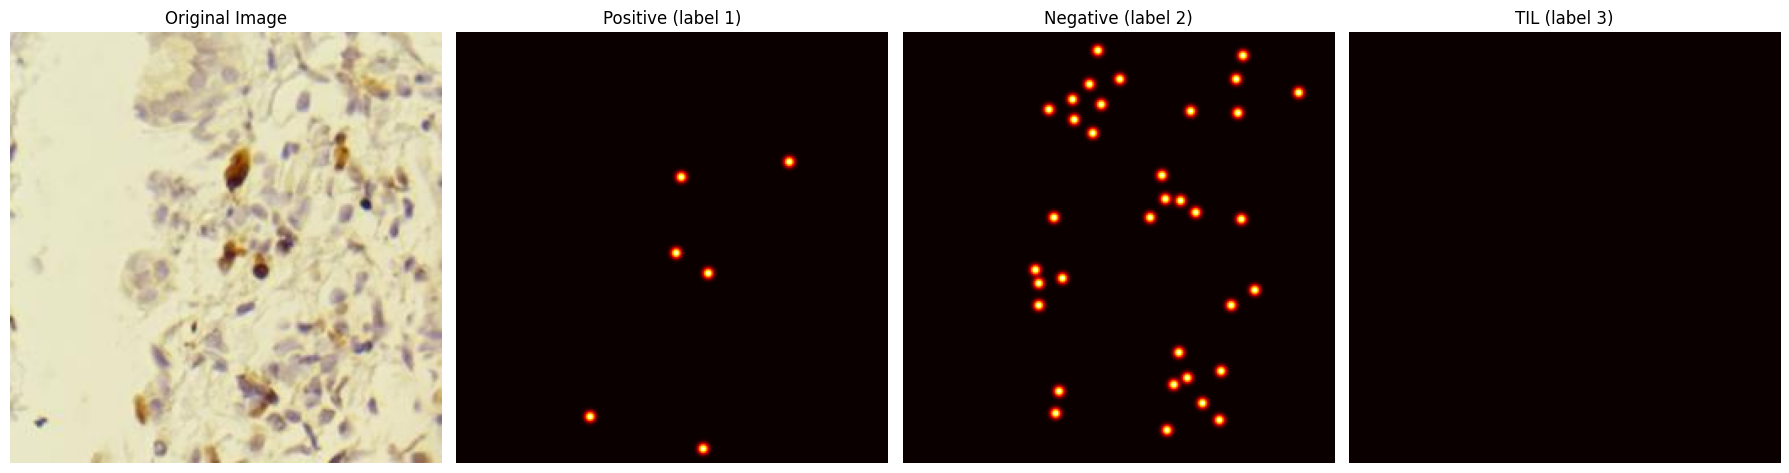

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

titles = [
    "Positive (label 1)",
    "Negative (label 2)",
    "TIL (label 3)"
]

for i in range(3):
    axes[i+1].imshow(Y[:, :, i], cmap="hot")
    axes[i+1].set_title(titles[i])
    axes[i+1].axis("off")

plt.tight_layout()
plt.show()


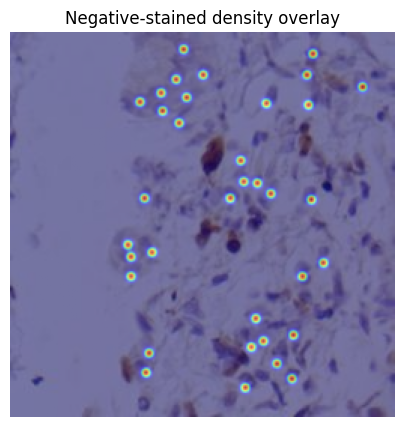

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.imshow(Y[:,:,1], cmap="jet", alpha=0.5)  # channel 1 = label_id 2
plt.title("Negative-stained density overlay")
plt.axis("off")
plt.show()


In [20]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf


In [46]:
def gaussian_2d(shape, sigma, center):
    h, w = shape
    y, x = np.ogrid[:h, :w]
    cy, cx = center

    g = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
    g = g / (2 * np.pi * sigma * sigma)   # 🔴 NORMALIZATION
    return g



def json_to_density_map(json_path, image_size=(256,256), sigma=2):
    H, W = image_size
    Y = np.zeros((H, W, 3), dtype=np.float32)

    with open(json_path, 'r') as f:
        annotations = json.load(f)

    for ann in annotations:
        x = ann["x"]
        y = ann["y"]
        c = ann["label_id"] - 1  # critical

        if 0 <= x < W and 0 <= y < H:
            Y[:, :, c] += gaussian_2d((H, W), (x, y), sigma)

    return Y


In [48]:
def load_sample(img_path, json_path):
    # image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # target
    Y = json_to_density_map(json_path)

    return img, Y


In [49]:
import os

def build_file_list(root_dir):
    files = []
    for name in os.listdir(root_dir):
        if name.endswith(".jpg"):
            img_path = os.path.join(root_dir, name)
            json_path = os.path.join(
                root_dir, name.replace(".jpg", ".json")
            )
            if os.path.exists(json_path):
                files.append((img_path, json_path))
            else:
                print("Missing label for:", img_path)
    return files


In [50]:
def data_generator(file_list):
    for img_path, json_path in file_list:
        X, Y = load_sample(img_path, json_path)
        yield X, Y


In [51]:
def make_dataset(file_list, batch_size=4, shuffle=True):
    ds = tf.data.Dataset.from_generator(
        lambda: data_generator(file_list),
        output_signature=(
            tf.TensorSpec(shape=(256,256,3), dtype=tf.float32),
            tf.TensorSpec(shape=(256,256,3), dtype=tf.float32)
        )
    )

    if shuffle:
        ds = ds.shuffle(20)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [52]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
train_files = build_file_list("/content/drive/MyDrive/train256")
test_files  = build_file_list("/content/drive/MyDrive/test256")

train_ds = make_dataset(train_files, batch_size=4)
test_ds  = make_dataset(test_files, batch_size=4, shuffle=False)


In [54]:
print("Train samples:", len(train_files))
print("Test samples:", len(test_files))
print(train_files[0])


Train samples: 1656
Test samples: 700
('/content/drive/MyDrive/train256/1336_0073_5.jpg', '/content/drive/MyDrive/train256/1336_0073_5.json')


In [36]:
# import numpy as np

# def gaussian_2d(shape, sigma, center):
#     h, w = shape
#     y, x = np.ogrid[:h, :w]
#     cy, cx = center
#     g = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
#     return g


In [55]:
import json

def json_to_density_map(json_path, img_shape=(256,256), num_classes=3, sigma=3):
    density = np.zeros((*img_shape, num_classes), dtype=np.float32)

    with open(json_path, "r") as f:
        points = json.load(f)

    for p in points:
        x = int(p["x"])
        y = int(p["y"])
        cls = int(p["label_id"]) - 1  # labels: 1,2,3 → channels: 0,1,2

        if 0 <= x < img_shape[1] and 0 <= y < img_shape[0]:
            density[:,:,cls] += gaussian_2d(
                img_shape,
                sigma=sigma,
                center=(y, x)
            )

    return density


Image shape: (256, 256, 3)
Density shape: (256, 256, 3)
Counts: [ 6.121339 10.999928  0.      ]


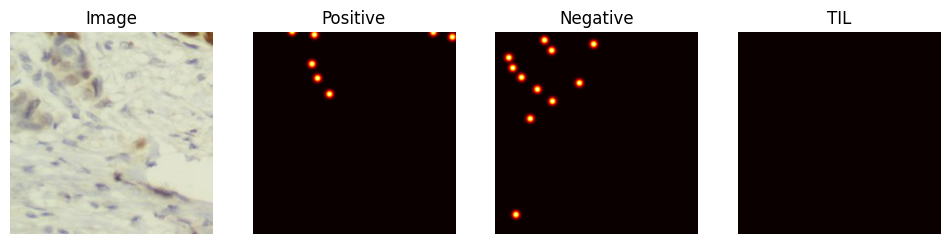

In [56]:
import matplotlib.pyplot as plt
from PIL import Image

img_path, json_path = train_files[0]

img = np.array(Image.open(img_path))
density = json_to_density_map(json_path)

print("Image shape:", img.shape)
print("Density shape:", density.shape)
print("Counts:", density.sum(axis=(0,1)))

plt.figure(figsize=(12,4))
plt.subplot(1,4,1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

for i, name in enumerate(["Positive", "Negative", "TIL"]):
    plt.subplot(1,4,i+2)
    plt.title(name)
    plt.imshow(density[:,:,i], cmap="hot")
    plt.axis("off")

plt.show()


In [57]:
import tensorflow as tf
from PIL import Image

IMG_SIZE = (256, 256)
NUM_CLASSES = 3

def load_sample(img_path, json_path):
    # Load image
    img = Image.open(img_path).convert("RGB")
    img = img.resize(IMG_SIZE)
    img = np.array(img, dtype=np.float32) / 255.0

    # Load density map
    density = json_to_density_map(
        json_path,
        img_shape=IMG_SIZE,
        num_classes=NUM_CLASSES,
        sigma=3
    )

    return img, density


In [58]:
def tf_load_sample(img_path, json_path):
    img, dens = tf.numpy_function(
        load_sample,
        [img_path, json_path],
        [tf.float32, tf.float32]
    )

    img.set_shape((256,256,3))
    dens.set_shape((256,256,3))
    return img, dens


In [59]:
def make_dataset(file_list, batch_size=4, shuffle=True):
    img_paths = [f[0] for f in file_list]
    json_paths = [f[1] for f in file_list]

    ds = tf.data.Dataset.from_tensor_slices((img_paths, json_paths))

    if shuffle:
        ds = ds.shuffle(len(file_list))

    ds = ds.map(tf_load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [60]:
BATCH_SIZE = 4

train_ds = make_dataset(train_files, BATCH_SIZE, shuffle=True)
test_ds  = make_dataset(test_files,  BATCH_SIZE, shuffle=False)


In [61]:
for x, y in train_ds.take(1):
    print(x.shape, y.shape)
    print("Counts:", tf.reduce_sum(y, axis=[1,2]))


(4, 256, 256, 3) (4, 256, 256, 3)
Counts: tf.Tensor(
[[31.916891   2.         0.       ]
 [49.763153  19.999985   0.       ]
 [ 0.         0.         0.       ]
 [ 2.9671946  0.         0.       ]], shape=(4, 3), dtype=float32)


In [ ]:
model = PathoNet(input_size=(256,256,3), classes=3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse"
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50
)


Model: "PathoNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 256, 256,  │        432 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_72[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_96      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 256, 256,  │      2,304 │ leaky_re_lu_96[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_73[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_97      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ leaky_re_lu_97[0… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 128, 128,  │      4,608 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 128, 128,  │      4,608 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_74[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_75[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_98      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_99      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 128, 128,  │          0 │ max_pooling2d_12… │
│ (Concatenate)       │ 32)               │            │ max_pooling2d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 128, 128,  │          0 │ leaky_re_lu_98[0… │
│                     │ 32)               │            │ leaky_re_lu_99[0… │
│                     │                   │            │ concatenate_24[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,247,659 (4.76 MB)

 Trainable params: 1,242,747 (4.74 MB)

 Non-trainable params: 4,912 (19.19 KB)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - loss: 0.7607 - val_loss: 0.3375
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 236s 570ms/step - loss: 0.2721 - val_loss: 0.1417
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 260s 567ms/step - loss: 0.1201 - val_loss: 0.0736
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 274s 597ms/step - loss: 0.0646 - val_loss: 0.0440
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 247s 595ms/step - loss: 0.0395 - val_loss: 0.0286
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 233s 562ms/step - loss: 0.0261 - val_loss: 0.0196
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 265s 570ms/step - loss: 0.0180 - val_loss: 0.0139
Epoch 8/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 249s 599ms/step - loss: 0.0127 - val_loss: 0.0100
Epoch 9/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 258s 592ms/step - loss: 0.0091 - val_loss: 0.0070
Epoch 10/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 264s 597ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 11/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 250s 569ms/step - loss: 0.0045 - val_loss: 0.1000
Epoch 12/50